# Importing and Pre-Processing the dataset

In [1]:
import pandas as pd

df = pd.read_csv("C:\\Users\\KIIT\\OneDrive\\Desktop\\Multilabel\\yeast.csv")
df = df.drop(columns=['id'])

df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.093700,0.139771,0.062774,0.007698,0.083873,-0.119156,0.073305,0.005510,0.027523,0.043477,...,0,0,0,0,0,0,0,0,0,0
1,-0.022711,-0.050504,-0.035691,-0.065434,-0.084316,-0.378560,0.038212,0.085770,0.182613,-0.055544,...,0,0,1,1,0,0,0,1,1,0
2,-0.090407,0.021198,0.208712,0.102752,0.119315,0.041729,-0.021728,0.019603,-0.063853,-0.053756,...,0,0,0,0,0,0,0,1,1,0
3,-0.085235,0.009540,-0.013228,0.094063,-0.013592,-0.030719,-0.116062,-0.131674,-0.165448,-0.123053,...,0,0,0,0,0,0,0,1,1,1
4,-0.088765,-0.026743,0.002075,-0.043819,-0.005465,0.004306,-0.055865,-0.071484,-0.159025,-0.111348,...,0,0,0,0,0,0,0,0,0,0


# Visualizing the label distribution


<AxesSubplot:>

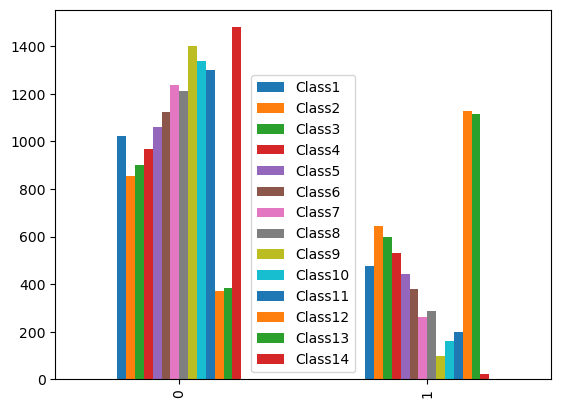

In [2]:
df1 = df[df.columns[103:]]
df2 = df1.apply(pd.value_counts).fillna(0)
df2.plot(kind="bar")

# MLSMOTE

In [3]:
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

def get_tail_label(data: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = data.sum(axis=0)
    irlbl = irlbl[(irlbl > np.quantile(irlbl,ql[0])) & ((irlbl < np.quantile(irlbl,ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = np.median(irlbl)
    tail_label = pd.Series(irlbl)[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    y_df = pd.DataFrame(y)
    X_df = pd.DataFrame(X)
    tail_labels = get_tail_label(y_df, ql=ql)
    index = y_df[y_df[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X_df[X_df.index.isin(index)].reset_index(drop = True)
    y_sub = y_df[y_df.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

# Preparing training DataFrame

In [4]:
from sklearn.model_selection import train_test_split

X_df = df[df.columns[0:103]]
y_df = df[df.columns[103:]]

X = np.asarray(X_df)
y = np.asarray(y_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_traindf = pd.DataFrame(X_train)
y_traindf = pd.DataFrame(y_train)
df_train = pd.concat([X_traindf, y_traindf], axis=1)
df_train.columns = range(df_train.shape[1])
df_train.T.reset_index(drop=True).T

X_sub, y_sub = get_minority_samples(X_train, y_train) # Getting minority samples of that datframe
X_res, y_res = MLSMOTE(X_sub, y_sub, 400, 5)  # Applying MLSMOTE to augment the dataframe

df_temp = pd.concat([X_res, y_res], axis=1)
df_temp.columns = range(df_temp.shape[1])
df_temp.T.reset_index(drop=True).T

df_train.reset_index(drop=True, inplace=True)
df_temp.reset_index(drop=True, inplace=True)
df_train = pd.concat([df_train, df_temp])
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,-0.083206,-0.121429,-0.159163,-0.078547,-0.055254,-0.013542,0.029635,-0.084545,0.013853,0.090194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.188013,0.055309,0.295751,0.251167,0.043524,0.044886,-0.104978,-0.098661,-0.119595,0.000599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.036868,0.100721,0.127483,0.179530,-0.039828,0.152586,0.009898,0.081388,0.071926,0.047411,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.205915,-0.046143,-0.028154,-0.033129,0.150096,0.132866,0.204030,0.116630,0.202036,0.143154,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,-0.055990,0.041369,0.060838,0.033668,0.067567,-0.005974,-0.063686,0.028767,-0.053437,-0.075653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


# Visualizing the resampled training labels

<AxesSubplot:>

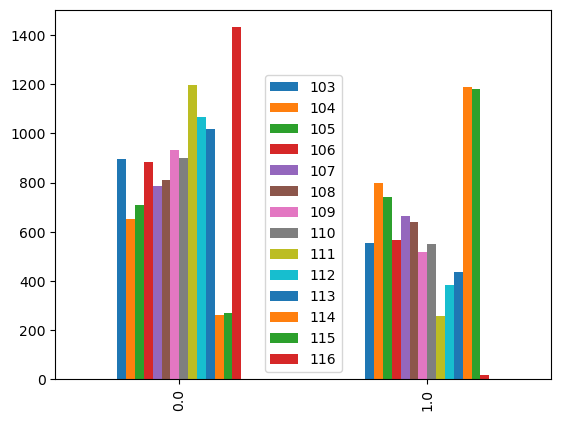

In [5]:
X_new = df_train[df_train.columns[0:103]]
y_new = df_train[df_train.columns[103:]]

df2 = y_new.apply(pd.value_counts).fillna(0)
df2.plot(kind="bar")